In [1]:
import os
import cv2

In [2]:
features = []
target = []
for x in ['without_mask','with_mask']:
    ImagesNamesList = os.listdir("/Users/Srushti/Documents/VerzeoAI/MaskData/" + x)
    for y in ImagesNamesList:
        imgarr = cv2.imread("/Users/Srushti/Documents/VerzeoAI/MaskData/" + x + "/" + y)
        try:
            imgarr = cv2.resize(imgarr,(100,100)) # Resizing images which can be resized
            features.append(imgarr)
        except:
            pass
        else:
            if x == 'without_mask':
                target.append(0)
            else:
                target.append(1)
        
    print("In Folder", x)

In Folder without_mask
In Folder with_mask


In [3]:
import numpy as np

In [4]:
features = np.array(features)

In [5]:
target = np.array(target)

In [6]:
features.shape #The width and height of the image will not be shown as each image is of different size

(3833, 100, 100, 3)

In [7]:
target.shape 

(3833,)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.2)

In [10]:
features_train.shape

(3066, 100, 100, 3)

In [11]:
target_train.shape

(3066,)

In [12]:
features_test.shape

(767, 100, 100, 3)

In [13]:
target_test.shape

(767,)

In [14]:
def preprocessing(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # Convert colored image to black and white
    image = image/255
    return image

In [15]:
features_train = np.array(list(map(preprocessing,features_train)))

In [16]:
features_train = features_train.reshape(3066,100,100,1)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
dataGen = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,shear_range=0.1)

In [19]:
dataGen.fit(features_train)

In [20]:
batches = dataGen.flow(features_train,target_train,batch_size=20)

In [21]:
images,labels = next(batches)

In [22]:
import matplotlib.pyplot as plt

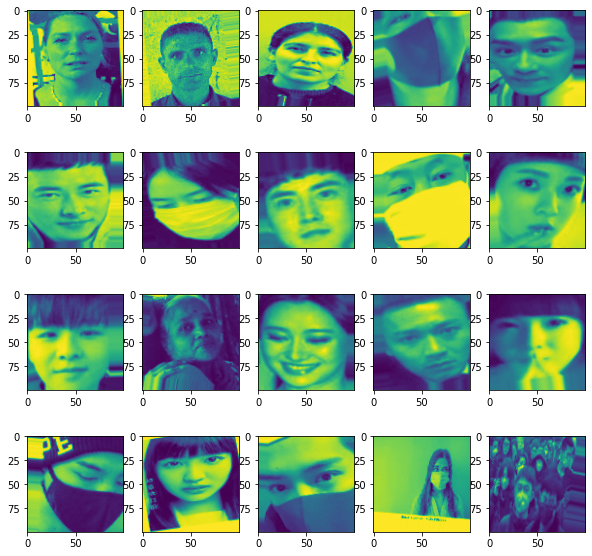

In [23]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i].reshape(100,100))

plt.show()

## One-hot-encoding to increase the number of output layers by increasing the number of neurons in output layer

In [24]:
from tensorflow.keras.utils import to_categorical

In [25]:
target_train=to_categorical(target_train)

In [26]:
target_train.shape

(3066, 2)

In [27]:
features_train.shape

(3066, 100, 100, 1)

# Step 1: Specify the architecture

In [28]:
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential

In [29]:
model = Sequential()
model.add(Conv2D(60,(3,3),activation="relu",input_shape=(100,100,1))) #Parameters: number of filters, filter-size, activation function, input shape of input layer
model.add(Conv2D(60,(3,3),activation="relu"))
#MaxPooling helps to reduce the size of the edge which helps in faster computation
model.add(MaxPooling2D((2,2))) # Size of the window
model.add(Conv2D(30,(3,3),activation="relu"))
model.add(Conv2D(30,(3,3),activation="relu"))
model.add(Conv2D(30,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5)) # Dropout 50% of the 500 neurons before the output layer
model.add(Flatten())
#actual neurons start here
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax")) # 2 neurons in output layer

# Step 2: Compile the model

In [30]:
from keras.optimizers import Adam

In [31]:
model.compile(Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

# Step 3: Train the model


In [71]:
model.fit(dataGen.flow(features_train,target_train,batch_size=20),epochs=20)

Epoch 1/20
154/154 [==============================] - 132s 812ms/step - loss: 0.6615 - accuracy: 0.5906
Epoch 2/20
154/154 [==============================] - 124s 802ms/step - loss: 0.5399 - accuracy: 0.7254
Epoch 3/20
154/154 [==============================] - 122s 793ms/step - loss: 0.4305 - accuracy: 0.8075
Epoch 4/20
154/154 [==============================] - 123s 798ms/step - loss: 0.3782 - accuracy: 0.8349
Epoch 5/20
154/154 [==============================] - 125s 809ms/step - loss: 0.3091 - accuracy: 0.8647
Epoch 6/20
154/154 [==============================] - 86647s 566s/step - loss: 0.2592 - accuracy: 0.8931
Epoch 7/20
154/154 [==============================] - 125s 813ms/step - loss: 0.2225 - accuracy: 0.9181
Epoch 8/20
154/154 [==============================] - 120s 782ms/step - loss: 0.2402 - accuracy: 0.8976
Epoch 9/20
154/154 [==============================] - 143s 926ms/step - loss: 0.2109 - accuracy: 0.9188
Epoch 10/20
154/154 [==============================] - 127s 825

# Step 4: Predict the model


In [32]:
from keras.models import model_from_json

In [73]:
model_json = model.to_json()
with open('verzeoAIMask.json',"w") as abc:
    abc.write(model_json)
    abc.close
    
model.save_weights("verzeoAIMask.h5")
print("Save the Model")

Save the Model


In [33]:
json_file = open('verzeoAIMask.json','r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('verzeoAIMask.h5')
print("Loaded Model Successfully")

Loaded Model Successfully


In [34]:
import numpy as np
import cv2

def getClassName(classNo):
    if classNo == 0: return 'Without Mask'
    elif classNo == 1: return 'With Mask'

In [35]:
capt = cv2.VideoCapture(0)
capt.set(3,640)
capt.set(4,480)
capt.set(10,180)
capt.open(0)

True

In [41]:
while True:
    cv2.startWindowThread()
    message,image = capt.read()
    imagearr = np.asarray(image)
    face_cascade = cv2.CascadeClassifier("/Users/Srushti/opt/anaconda3/lib/python3.8/site-packages/cv2/data/haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.05,3)
    for (x,y,w,h) in faces:
        detectedFace = image[x:x+w,y:y+h]
        detectedFace = cv2.resize(detectedFace,(100,100))
        detectedFace = preprocessing(detectedFace)
        detectedFace = detectedFace.reshape(1,100,100,1)
        predictions = loaded_model.predict(detectedFace)
        classIndex = loaded_model.predict_classes(imagearr)
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
        if probabilityValue>0.75:
            cv2.putText(image,getClassName(classIndex),(x,y-3),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
            cv2.putText(image,str(int(probabilityValue * 100)) + " %",(x+w+20,y-3),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
        cv2.imshow("Model Prediction",image)
        returnedValue = cv2.waitKey(1)
        if returnedValue == ord('s') or returnedValue == ord('S'):
            cv2.destroyAllWindows()
            break

ValueError: in user code:

    /Users/Srushti/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1544 predict_function  *
        return step_function(self, iterator)
    /Users/Srushti/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1527 run_step  *
        outputs = model.predict_step(data)
    /Users/Srushti/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1500 predict_step  *
        return self(x, training=False)
    /Users/Srushti/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/Srushti/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:227 assert_input_compatibility  *
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 1280, 3)
